## Análisis exploratorio y preparación del dataset

Vamos a analizar el dataset sucio para identificar problemas en los datos. Para ello, realizaremos los siguientes pasos en **`cell_diagnosis_dev`**:

1. Mostramos un fragmento aleatorio del dataset (7 filas) para observar su estructura.
2. Verificamos los valores mínimos y máximos en cada columna para detectar posibles valores fuera de rango.
3. Buscamos valores faltantes en todas las características.
4. Identificamos filas duplicadas en el dataset.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Problema1.src.visualization import explore_data

df_dev = pd.read_csv("Problema1/data/raw/cell_diagnosis_dev.csv")
df_test = pd.read_csv("Problema1/data/raw/cell_diagnosis_test.csv")

explore_data(df_dev)

Fragmento aleatorio de muestras


,CellSize,CellShape,NucleusDensity,ChromatinTexture,CytoplasmSize,CellAdhesion,MitosisRate,NuclearMembrane,GrowthFactor,OxygenSaturation,Vascularization,InflammationMarkers,Diagnosis,CellType,GeneticMutation
540,67.075531,0.513420,1.462799,23.065165,25.560686,0.453527,3.425160,2.408596,57.606621,77.790439,5.511870,41.557389,0.0,Mesnchymal,Presnt
935,68.330224,0.453829,1.408824,21.364690,30.849165,0.504717,2.722125,2.319955,62.134339,79.482342,4.247419,NaN,1.0,???,Absnt
1084,72.836925,0.492583,NaN,19.728214,NaN,0.460935,3.303121,2.623966,57.854679,82.036207,4.692234,45.080480,0.0,???,Presnt
1432,NaN,0.520806,1.479086,21.518950,24.349450,0.495544,3.320548,2.378072,62.296589,78.170878,5.003658,45.193630,0.0,Epthlial,Absnt
837,65.638014,0.504440,NaN,22.934530,27.006970,0.483478,3.321207,2.496253,56.151487,-10.000000,5.065398,NaN,0.0,Mesnchymal,Absnt
786,67.385373,-1.413038,5.902661,22.036169,24.856200,-3.327849,2.931316,NaN,61.157828,80.755679,NaN,43.157302,0.0,Epthlial,Presnt
1427,74.788173,0.463556,1.432732,23.783648,30.237031,0.421185,3.011530,2.023761,63.967154,79.715836,NaN,NaN,0.0,???,Presnt



Rango de valores de cada columna


,CellSize,CellShape,NucleusDensity,ChromatinTexture,CytoplasmSize,CellAdhesion,MitosisRate,NuclearMembrane,GrowthFactor,OxygenSaturation,Vascularization,InflammationMarkers,Diagnosis
min,-100.0,-1.413038,-3.0,10.000000,5.000000,-4.461755,-50.0,-3.438990,-50.000000,-10.000000,-0.997057,0.000000,0.0
max,1000.0,5.048566,50.0,263.793425,299.350559,5.029925,100.0,24.871762,563.622684,807.181058,54.512433,440.902261,1.0



Categorías con valores faltantes
 CellSize               330
CellShape              316
NucleusDensity         301
ChromatinTexture       297
CytoplasmSize          316
CellAdhesion           294
MitosisRate            320
NuclearMembrane        320
GrowthFactor           304
OxygenSaturation       288
Vascularization        316
InflammationMarkers    305
CellType               256

Filas duplicadas: 0


De la exploración inicial identificamos varios aspectos clave a considerar antes de entrenar cualquier modelo.

En primer lugar, observamos la presencia de **columnas categóricas** que deben ser transformadas a valores numéricos:

- La columna **`GeneticMutation`** tiene valores como `Presnt` y `Absnt`, por lo que puede codificarse con **label encoding** al tratarse de una variable binaria.
- La columna **`CellType`** presenta categorías como `Epthlial` y `Mesnchymal`. Al no haber un orden natural entre estas clases, se utilizará **one-hot encoding**, que permite representar cada tipo como una variable independiente sin introducir una jerarquía artificial.

Por otro lado, hay una **gran cantidad de valores faltantes (`NaN`)**, distribuidos en prácticamente **todas las columnas**, tanto numéricas como categóricas. Será necesario definir una estrategia para tratarlos, ya sea mediante imputación o eliminación, según el caso y la distribución de los datos.

Además, se identificaron múltiples **valores fuera de rango** en variables numéricas, como por ejemplo **valores negativos en tamaños celulares** o medidas biológicas que, en principio, no deberían asumir dichos valores. Es importante distinguir entre errores de medición y posibles **valores atípicos reales**, ya que algunos podrían representar condiciones clínicas particulares.

Como siguiente paso, vamos a transformar las variables categóricas a formato numérico para poder:

- Generar una **matriz de correlación** entre variables numéricas y categorizadas.
- Visualizar mediante **boxplots** la distribución de cada variable, lo cual nos ayudará a:
  - Identificar outliers.
  - Analizar la presencia y posible tratamiento de los valores faltantes.

       CellSize  CellShape  NucleusDensity  ChromatinTexture  CytoplasmSize  \
1391  69.755349   0.510941        1.442396         22.027739      29.147289   
1043  69.881673        NaN        1.513760         20.624256            NaN   
133   66.501166   0.523608        1.485591               NaN      27.104205   
1456  71.117392   0.533759        1.484089               NaN      26.981522   
911   66.329991   0.552484        1.498025         22.028492      27.831337   
568   77.511381   0.515621        1.310057         21.154253      29.100535   
293         NaN   0.524801        1.375986         20.032220      31.523662   

      CellAdhesion  MitosisRate  NuclearMembrane  GrowthFactor  \
1391      0.472229     3.025516         2.253797     60.983655   
1043      0.420192          NaN         2.482899           NaN   
133       0.456614     3.415585         2.415108     55.549676   
1456      0.473866     3.288234         2.598681     57.100151   
911       0.488993          NaN      

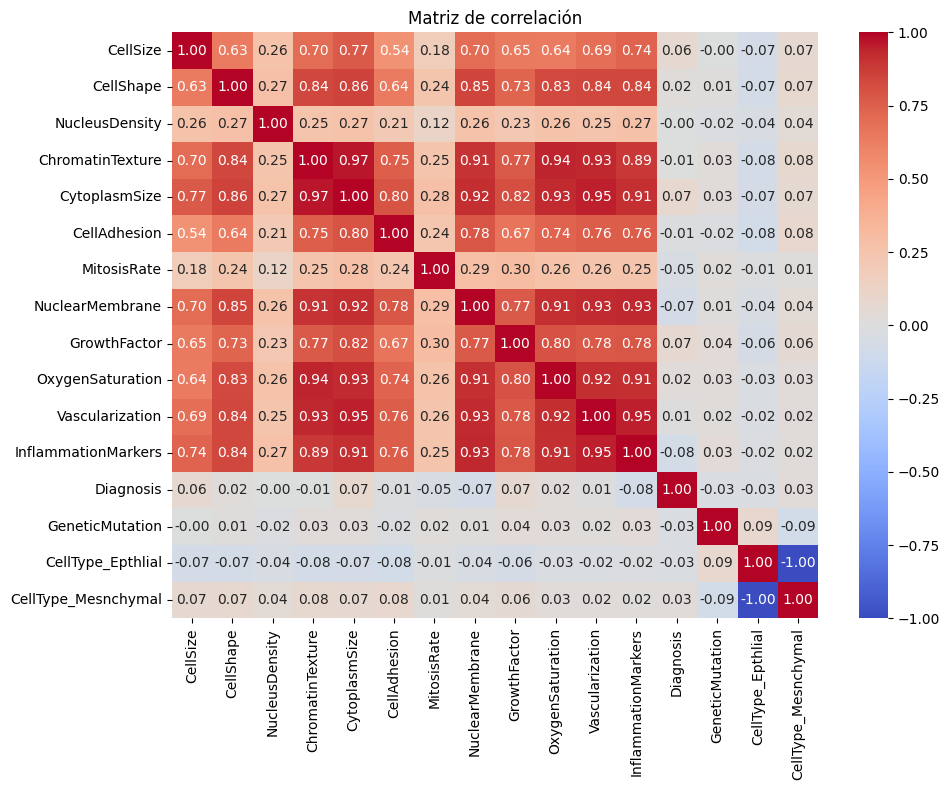

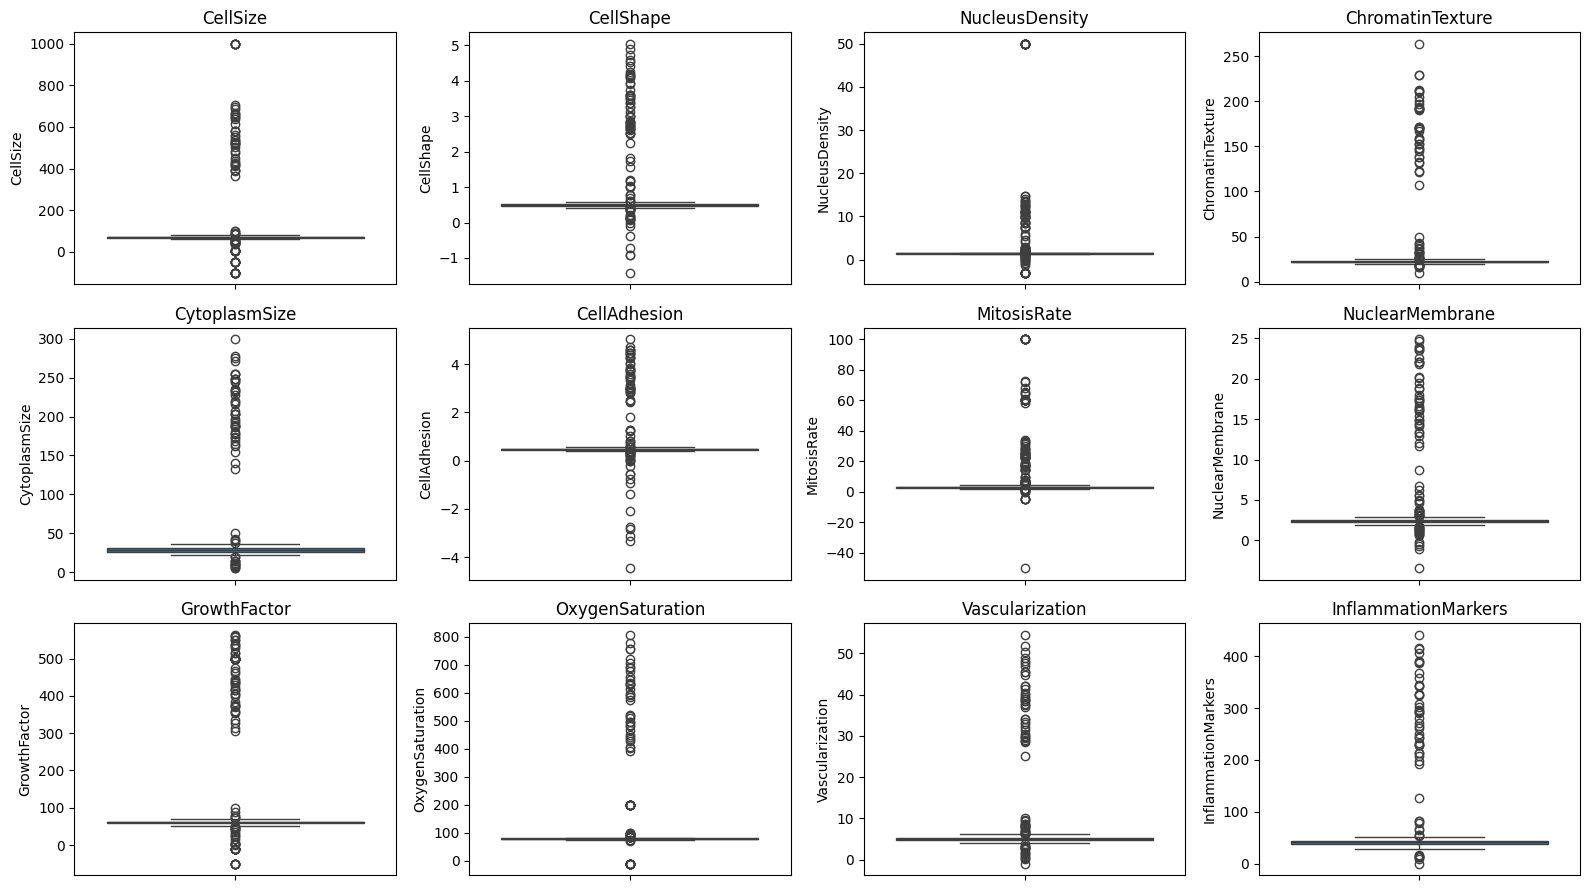

In [2]:
from Problema1.src.preprocessing import label_encode, one_hot_encode
from Problema1.src.visualization import plot_correlation_matrix, plot_boxplots
df_dev = label_encode(df_dev, 'GeneticMutation', {"Presnt": 1, "Absnt": 0})
df_dev = one_hot_encode(df_dev, 'CellType', ['Epthlial', 'Mesnchymal'])
df_test = label_encode(df_test, 'GeneticMutation', {"Presnt": 1, "Absnt": 0})
df_test = one_hot_encode(df_test, 'CellType', ['Epthlial', 'Mesnchymal'])
print(df_dev.sample(7))
plot_correlation_matrix(df_dev)
plot_boxplots(df_dev, ['Diagnosis', 'CellType_Epthlial', 'CellType_Mesnchymal', 'GeneticMutation'])


A partir de los **boxplots**, observamos que la mayoría de las variables numéricas presentan valores concentrados en rangos razonables, aunque también se detectan **anomalias leves** que se desvían ligeramente de esos rangos centrales. Sin embargo, el aspecto más llamativo es la presencia de **valores extremadamente alejados**, lo que sugiere posibles outliers severos o errores de carga.

Dado este panorama, vamos a comenzar utilizando el método del **rango intercuartílico (IQR)** para detectar estos valores extremos.

In [3]:
from Problema1.src.preprocessing import clean_outliers_iqr

df_dev_clean = clean_outliers_iqr(df_dev)
print("\nRango de valores de cada columna")
display(df_dev_clean.describe().loc[['min', 'max']])


Rango de valores de cada columna


,CellSize,CellShape,NucleusDensity,ChromatinTexture,CytoplasmSize,CellAdhesion,MitosisRate,NuclearMembrane,GrowthFactor,OxygenSaturation,Vascularization,InflammationMarkers,Diagnosis,GeneticMutation,CellType_Epthlial,CellType_Mesnchymal
min,59.664732,0.416204,1.270346,19.048505,22.405899,0.399282,1.85118,1.839782,52.310981,76.423807,3.975933,29.230605,0.0,0.0,0.0,0.0
max,80.098648,0.585717,1.594042,25.121912,35.677650,0.545982,4.31025,2.927208,69.906705,83.534983,6.141619,51.468515,1.0,1.0,1.0,1.0


Aunque el método del **`rango intercuartílico (IQR)`** logra filtrar varios valores que claramente se alejan de la distribución típica, también presenta una limitación importante: puede **eliminar valores válidos** que simplemente están en los extremos del rango natural de las variables, lo cual puede ser relevante en contextos clínicos donde los **casos aislados** son justamente los más críticos.

Por esta razón, y a partir de lo observado en los **`boxplots`**, decidimos definir de forma **manual los límites de los outliers** para cada variable. Esta decisión nos permite construir un dataset más robusto frente a **`anomalías reales`**, sin descartar información valiosa por ajustarnos a un criterio estadístico rígido. Al mismo tiempo, podremos descartar aquellos **valores extremos** que, por su magnitud, es muy probable que correspondan a **errores de carga o medición**.  
En lugar de eliminarlos, optamos por **reemplazarlos por valores faltantes (`NaN`)**, asumiendo que se trata de datos erróneos pero con la intención de **no perder por completo esas instancias**. Esto nos permite tratarlos luego mediante estrategias de imputación, preservando la mayor cantidad posible de información útil.

In [4]:
from Problema1.src.preprocessing import clean_outliers
limits = {
'CellSize': (0, 200), 'CellShape': (0, np.inf), 'CellAdhesion': (0, 1),
'NucleusDensity': (0, 20), 'MitosisRate': (0, 50), 'NuclearMembrane': (1, 5), 
'GrowthFactor': (0, 200), 'OxygenSaturation': (0, 100), 'Vascularization': (0, 10),
'InflammationMarkers': (0, 100), 'CytoplasmSize': (-np.inf, 100), 'ChromatinTexture': (0, 100),
}
clean_outliers(df_dev, limits)
clean_outliers(df_test, limits)
print("\nRango de valores de cada columna")
display(df_dev.describe().loc[['min', 'max']])


Rango de valores de cada columna


,CellSize,CellShape,NucleusDensity,ChromatinTexture,CytoplasmSize,CellAdhesion,MitosisRate,NuclearMembrane,GrowthFactor,OxygenSaturation,Vascularization,InflammationMarkers,Diagnosis,GeneticMutation,CellType_Epthlial,CellType_Mesnchymal
min,2.735933,0.063622,0.097131,10.0,5.0,0.0,0.00000,1.0,0.0,70.0,0.082936,0.00000,0.0,0.0,0.0,0.0
max,100.000000,5.048566,14.792103,50.0,50.0,1.0,33.73935,5.0,100.0,100.0,10.000000,82.21663,1.0,1.0,1.0,1.0


Ahora que contamos con un dataset **limpio y sin outliers erróneos**, estamos en condiciones de **dividir la información** en conjuntos de **`entrenamiento (train)`** y **`validación (validation)`**, lo cual nos permitirá aplicar los próximos pasos de preprocesamiento de forma más controlada y consistente sobre los datos que realmente se usarán para entrenar los modelos.

In [5]:
from Problema1.src.preprocessing import train_val_split
# Separar features y target
X = df_dev.drop("Diagnosis", axis=1)
y = df_dev["Diagnosis"]
X_test = df_test.drop("Diagnosis", axis=1)
y_test = df_test["Diagnosis"]
X_train, X_val, y_train, y_val = train_val_split(X, y, split=0.8)

Ahora con el dataset separado, realizaremos la **`normalización`** de los datos numéricos para asegurar que todas las variables se encuentren en escalas comparables.

Para las variables que presentan **valores atípicos o distribuciones con colas largas**, utilizaremos un **`RobustScaler`**, ya que este método se basa en la mediana y el rango intercuartílico, siendo **menos sensible a los outliers**.

En cambio, para aquellas variables con **rangos bien definidos y sin presencia significativa de anomalías**, aplicaremos un **`MinMaxScaler`**, que transforma los datos a un rango entre 0 y 1, preservando la forma de la distribución original.

Además, para evitar cualquier tipo de **data leakage**, los parámetros de escalado (como la mediana, percentiles, mínimo y máximo) se calcularán **únicamente sobre el conjunto de `train`**, y luego se aplicarán tanto a los datos de **`validación`** como a los de **`test`**, garantizando una simulación más realista del entorno de predicción.

In [6]:
from Problema1.src.preprocessing import robust_fit, minmax_fit, robust_transform, minmax_transform

# Features a escalar
features_robust = ['CellShape', 'NucleusDensity', 'MitosisRate', 'GrowthFactor', 'ChromatinTexture', 'CytoplasmSize']
features_minmax = ['NuclearMembrane', 'OxygenSaturation', 'Vascularization', 'InflammationMarkers']

# Fit con train
mediana, iqr = robust_fit(X_train[features_robust])
minimos, maximos = minmax_fit(X_train[features_minmax])

# Transform
X_train[features_robust] = robust_transform(X_train[features_robust], mediana, iqr)
X_val[features_robust] = robust_transform(X_val[features_robust], mediana, iqr)
X_test[features_robust] = robust_transform(X_test[features_robust], mediana, iqr)

X_train[features_minmax] = minmax_transform(X_train[features_minmax], minimos, maximos)
X_val[features_minmax] = minmax_transform(X_val[features_minmax], minimos, maximos)
X_test[features_minmax] = minmax_transform(X_test[features_minmax], minimos, maximos)

Dado que una gran parte del dataset presenta **valores faltantes (`NaN`)**, eliminarlos directamente implicaría perder una cantidad significativa de datos, lo cual no es viable. Por eso, optamos por **imputar los valores faltantes**.

Sin embargo, debido a la presencia de **outliers y distribuciones no simétricas**, reemplazar los `NaN` con la **media o mediana** de cada variable podría introducir sesgos o valores poco representativos. En cambio, aplicamos una estrategia más robusta: reemplazamos **temporalmente** todos los `NaN` por la **mediana** (excepto en una columna por vez), y luego imputamos dicha columna utilizando un **`KNN Imputer`**.

Elegimos utilizar **KNN** porque **se basa en la similitud entre muestras**, lo que permite estimar los valores faltantes considerando el contexto multivariable de cada observación. Esta estrategia resulta especialmente adecuada dado que, como vimos en la **matriz de correlación**, existen **relaciones significativas entre muchas variables** del dataset. Esto le da al KNN información útil para imputar de forma más coherente que un valor fijo como la media o mediana.

Este proceso se repite para cada columna con valores faltantes, mejorando así la calidad general del dataset sin perder registros.

In [7]:
from Problema1.src.preprocessing import knn_regression

X_train_ref = X_train.copy()
X_train_ref = X_train_ref.fillna(X_train_ref.median(numeric_only=True))

# Columnas numéricas
columnas = [
    'CellSize', 'CellShape', 'NucleusDensity', 'ChromatinTexture', 'CytoplasmSize', 
    'CellAdhesion', 'MitosisRate', 'NuclearMembrane', 'GrowthFactor', 
    'OxygenSaturation', 'Vascularization', 'InflammationMarkers'
]

# Imputar con KNN
for col in columnas:
    X_train = knn_regression(X_train, X_train_ref, col, k=5)
    X_val = knn_regression(X_val, X_train_ref, col, k=5)
    X_test = knn_regression(X_test, X_train_ref, col, k=5)

# Columna binaria
X_train = knn_regression(X_train, X_train_ref, 'CellType_Epthlial', k=5, binary=True)
X_val = knn_regression(X_val, X_train_ref, 'CellType_Epthlial', k=5, binary=True)
X_test = knn_regression(X_test, X_train_ref, 'CellType_Epthlial', k=5, binary=True)
for df in [X_train, X_val, X_test]:
    df["CellType_Mesnchymal"] = df["CellType_Epthlial"].apply(
        lambda x: 1 - x if pd.notna(x) else np.nan
    )


# Verificación
df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)
df_dev = pd.concat([df_train, df_val], axis=0)
df_test = pd.concat([X_test, y_test], axis=1)
df_dev.to_csv("Problema1/data/processed/cell_diagnosis_dev.csv", index=False)
df_test.to_csv("Problema1/data/processed/cell_diagnosis_test.csv", index=False)


OSError: Cannot save file into a non-existent directory: 'Problema1\data\processed'

A continuación, implementaremos una **clase de regresión logística binaria** utilizando los datos ya preprocesados. El primer paso consistirá en realizar una **búsqueda de hiperparámetros** utilizando el conjunto de **entrenamiento (`train`) y validación (`validation`)**. 

Vamos a explorar diferentes combinaciones de **regularización L2**, **learning rate** y **umbral de clasificación (`threshold`)** con el objetivo de encontrar la configuración que permita un mejor rendimiento del modelo.

In [ ]:
from Problema1.src.utils import train_best_logistic_model
model = train_best_logistic_model(X_train, y_train, X_val, y_val)

c:\Users\bianc\Machine\Bianchi_Martin_TP2\Problema1\src\models.py:20: RuntimeWarning: overflow encountered in exp
  return np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))
c:\Users\bianc\Machine\Bianchi_Martin_TP2\Problema1\src\models.py:20: RuntimeWarning: invalid value encountered in divide
  return np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))
c:\Users\bianc\Machine\Bianchi_Martin_TP2\Problema1\src\models.py:26: RuntimeWarning: overflow encountered in matmul
  h = self.sigmoid(self.X @ b0)
c:\Users\bianc\Machine\Bianchi_Martin_TP2\Problema1\src\models.py:35: RuntimeWarning: overflow encountered in multiply
  grad[1:] += 2 * self.L2 * b0[1:]  # solo regularizamos del índice 1 en adelante
c:\Users\bianc\Machine\Bianchi_Martin_TP2\Problema1\src\models.py:43: RuntimeWarning: invalid value encountered in subtract
  self.coef -= self.lr * self.gradiente(self.coef)
c:\Users\bianc\Machine\Bianchi_Martin_TP2\Problema1\src\models.py:26: RuntimeWarning:

Una vez definido el modelo con los **mejores hiperparámetros**, procedemos a **evaluar su rendimiento** sobre los datos de validación.

Vamos a reportar distintas **`métricas de performance`** para obtener una visión completa del comportamiento del clasificador:

- **Matriz de confusión**
- **Accuracy**
- **Precision**
- **Recall**
- **F-Score**
- **Curva Precision-Recall (PR)**
- **Curva ROC**
- **Área bajo la curva ROC (AUC-ROC)**
- **Área bajo la curva PR (AUC-PR)**

,learning_rate,threshold,L2,weights
Hyperparameters,0.01,0.868687,0.1,None


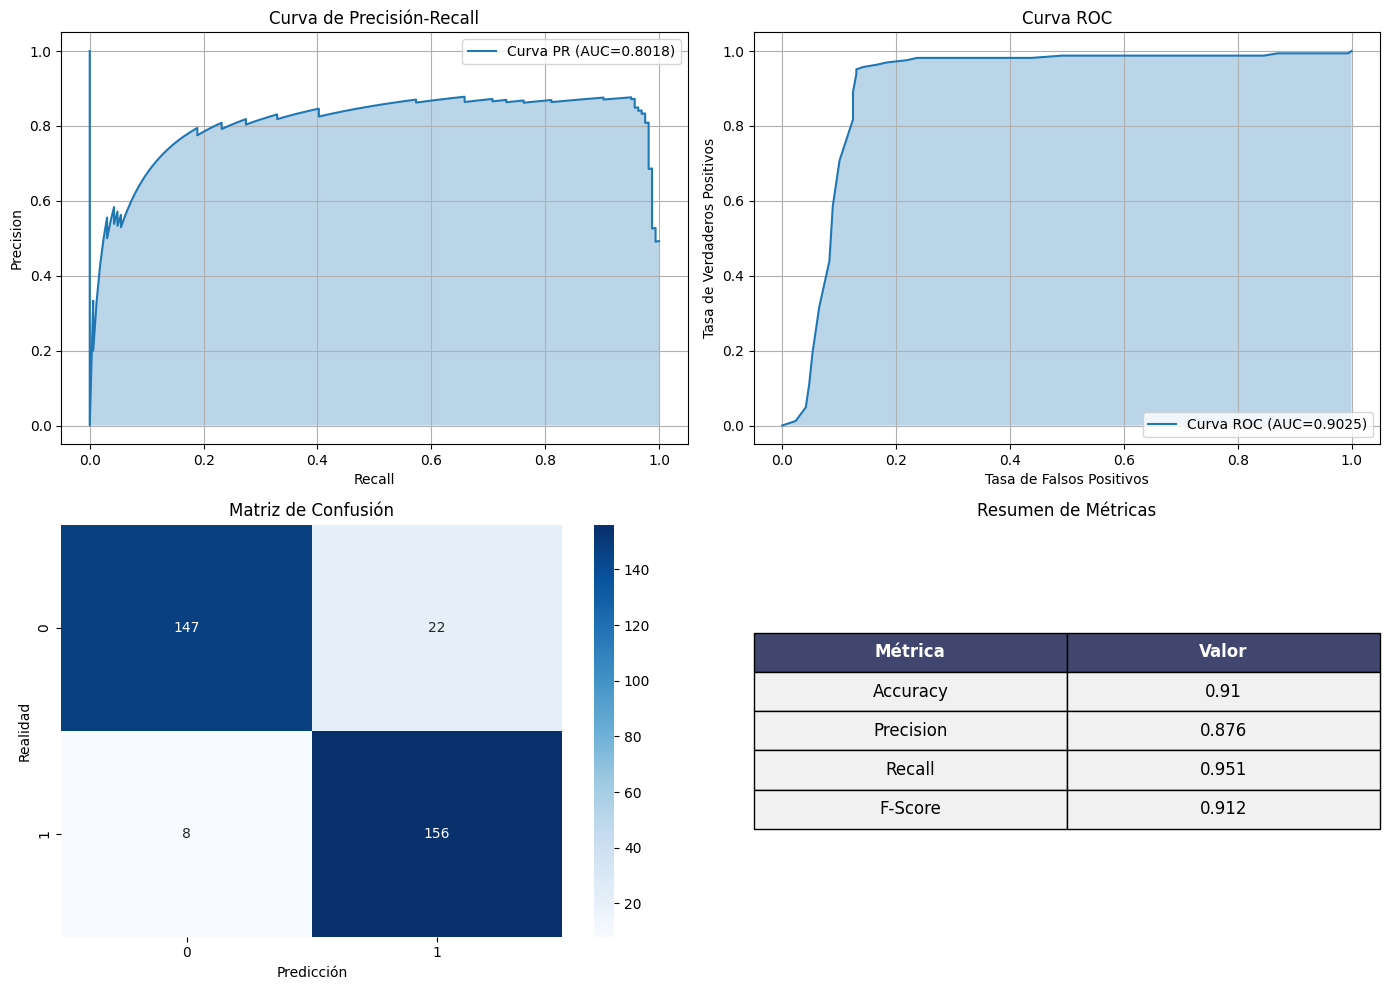

In [ ]:
from Problema1.src.metrics import accuracy, matriz_de_confusion
from Problema1.src.visualization import plot_metrics_summary
model.show_hyperparameters()
y_scores = model.predict_proba(X_val)
y_pred = model.predict(X_val)
plot_metrics_summary(y_val, y_scores, y_pred)


Una vez analizadas las **métricas obtenidas**, observamos un desempeño **consistente y robusto** del modelo. Destaca especialmente la **`baja cantidad de falsos negativos`** en comparación con los falsos positivos, lo cual es **crítico en escenarios médicos**, ya que preferimos un modelo que minimice los riesgos de no detectar una enfermedad, priorizando la prevención y el cuidado de la salud. Este balance entre falsos positivos y falsos negativos resulta **favorable para la predicción de enfermedades**, alineándose con los objetivos planteados.  

Ahora aplicaremos las **mismas métricas** al **conjunto de datos de test**, con el propósito de validar la **capacidad de generalización** y garantizar que el rendimiento del modelo se mantenga en datos no vistos.

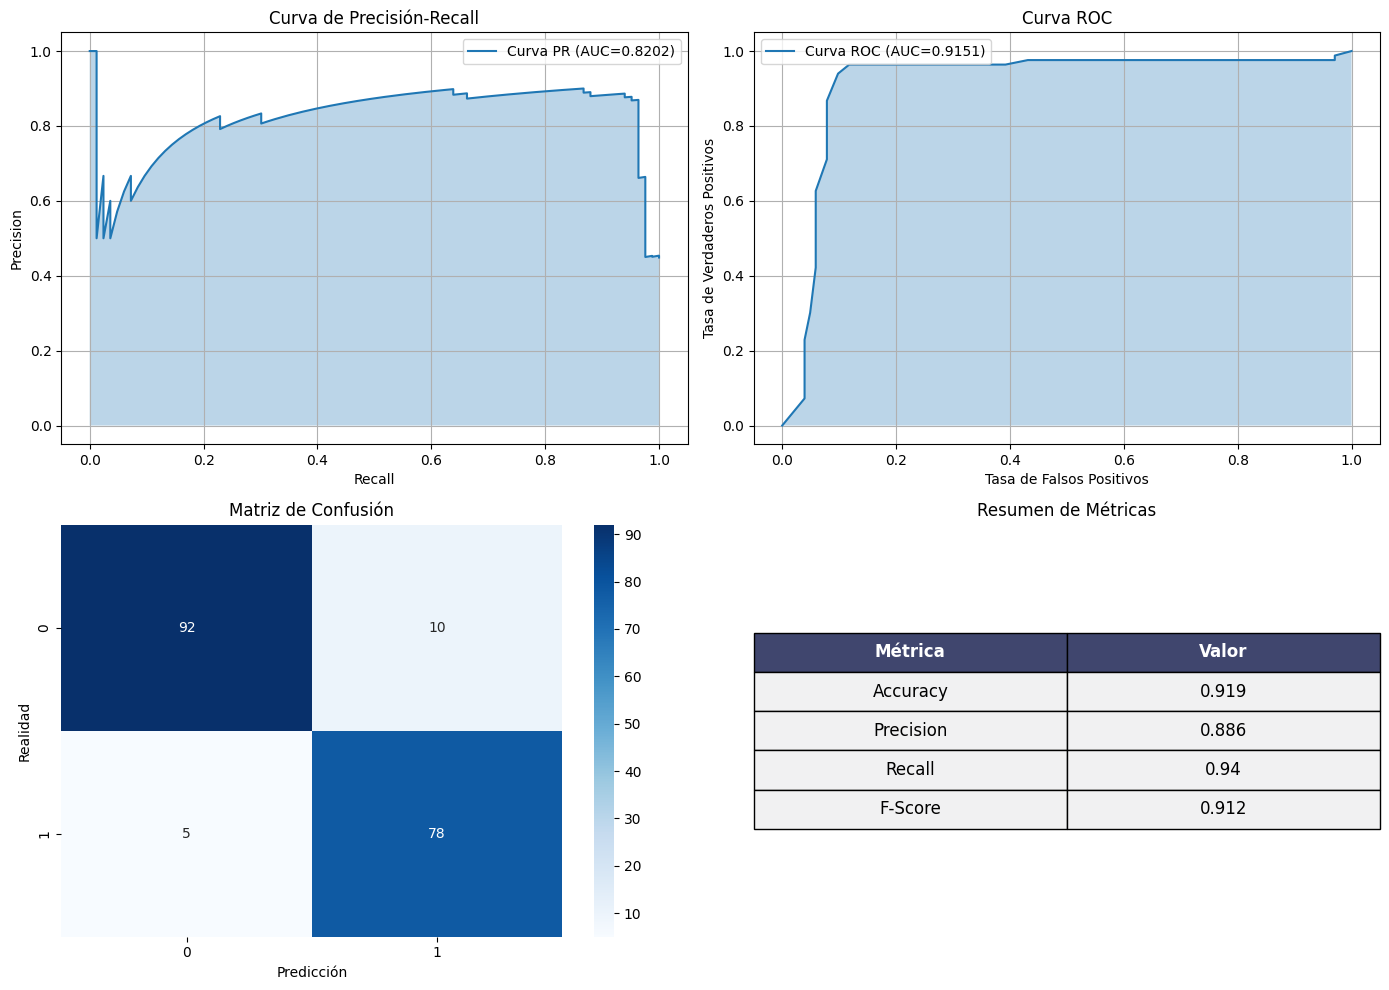

In [ ]:
X_test = df_test.drop("Diagnosis", axis=1)
y_test = df_test["Diagnosis"]
y_scores = model.predict_proba(X_test)
y_pred = model.predict(X_test)
plot_metrics_summary(y_test, y_scores, y_pred)

El desempeño del modelo sobre el conjunto de `test` mostró **muy buenas métricas**, incluso **ligeramente superiores** a las obtenidas durante la validación. Esto refuerza la idea de que el modelo logra **generalizar correctamente** y no presenta problemas de sobreajuste. 

Con un buen control sobre el `dataset` y el `modelo`, avanzamos hacia una nueva etapa en la que evaluaremos su rendimiento frente a un conjunto de datos **desbalanceado**. En este escenario, probaremos distintos métodos de balanceo para observar cómo varía la performance del modelo:

- Entrenamiento **sin rebalanceo**
- Uso de `undersampling`
- Uso de `oversampling`
- Aplicación de `SMOTE`
- Incorporación de `weight cost`

Esto nos permitirá comparar enfoques y analizar cuál de ellos ofrece mejores resultados en presencia de un desbalance en las clases. Para comenzar con este análisis, primero realizaremos la **limpieza de los datos**.

In [ ]:
# Carga y codificación
df_dev = pd.read_csv("Problema1/data/raw/cell_diagnosis_dev_imbalanced.csv")
df_test = pd.read_csv("Problema1/data/raw/cell_diagnosis_test_imbalanced.csv")

df_dev = label_encode(df_dev, 'GeneticMutation', {"Presnt": 1, "Absnt": 0})
df_dev = one_hot_encode(df_dev, 'CellType', ['Epthlial', 'Mesnchymal'])
df_test = label_encode(df_test, 'GeneticMutation', {"Presnt": 1, "Absnt": 0})
df_test = one_hot_encode(df_test, 'CellType', ['Epthlial', 'Mesnchymal'])

# Limpieza
clean_outliers(df_dev, limits)
clean_outliers(df_test, limits)

# Split
X = df_dev.drop("Diagnosis", axis=1)
y = df_dev["Diagnosis"]
X_train, X_val, y_train, y_val = train_val_split(X, y, split=0.8)
X_test = df_test.drop("Diagnosis", axis=1)
y_test = df_test["Diagnosis"]

# Escalado
mediana, iqr = robust_fit(X_train[features_robust])
minimos, maximos = minmax_fit(X_train[features_minmax])

for df in [X_train, X_val, X_test]:
    df[features_robust] = robust_transform(df[features_robust], mediana, iqr)
    df[features_minmax] = minmax_transform(df[features_minmax], minimos, maximos)

# Imputación
columnas = [
    'CellSize', 'CellShape', 'NucleusDensity', 'ChromatinTexture', 'CytoplasmSize', 
    'CellAdhesion', 'MitosisRate', 'NuclearMembrane', 'GrowthFactor', 
    'OxygenSaturation', 'Vascularization', 'InflammationMarkers'
]

X_train_ref = X_train.copy().fillna(X_train.median(numeric_only=True))

for col in columnas:
    X_train = knn_regression(X_train, X_train_ref, col, k=5)
    X_val = knn_regression(X_val, X_train_ref, col, k=5)
    X_test = knn_regression(X_test, X_train_ref, col, k=5)

X_train = knn_regression(X_train, X_train_ref, 'CellType_Epthlial', k=5, binary=True)
X_val = knn_regression(X_val, X_train_ref, 'CellType_Epthlial', k=5, binary=True)
X_test = knn_regression(X_test, X_train_ref, 'CellType_Epthlial', k=5, binary=True)
for df in [X_train, X_val, X_test]:
    df["CellType_Mesnchymal"] = df["CellType_Epthlial"].apply(
        lambda x: 1 - x if pd.notna(x) else np.nan
    )

df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)
df_dev = pd.concat([df_train, df_val], axis=0)
df_test = pd.concat([X_test, y_test], axis=1)


Aplicada la limpieza, entrenamos un modelo de regresión logística sobre cada una de las versiones balanceadas del dataset. En cada caso se realizó una búsqueda de los **mejores hiperparámetros**, de forma que cada modelo esté optimizado para su respectiva técnica de balanceo.

Con los modelos entrenados, reportamos sus **métricas de validación** para poder compararlos directamente, observando cómo afecta cada estrategia al desempeño general. Además, graficamos las curvas **`ROC`** y **`Precision-Recall (PR)`** en un mismo gráfico por métrica, lo que nos permitió analizar visualmente las diferencias entre métodos en cuanto a **precisión, sensibilidad y robustez frente al desbalance**.

c:\Users\bianc\Machine\Bianchi_Martin_TP2\Problema1\src\models.py:20: RuntimeWarning: overflow encountered in exp
  return np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))
c:\Users\bianc\Machine\Bianchi_Martin_TP2\Problema1\src\models.py:20: RuntimeWarning: invalid value encountered in divide
  return np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))
c:\Users\bianc\Machine\Bianchi_Martin_TP2\Problema1\src\models.py:26: RuntimeWarning: overflow encountered in matmul
  h = self.sigmoid(self.X @ b0)
c:\Users\bianc\Machine\Bianchi_Martin_TP2\Problema1\src\models.py:35: RuntimeWarning: overflow encountered in multiply
  grad[1:] += 2 * self.L2 * b0[1:]  # solo regularizamos del índice 1 en adelante
c:\Users\bianc\Machine\Bianchi_Martin_TP2\Problema1\src\models.py:43: RuntimeWarning: invalid value encountered in subtract
  self.coef -= self.lr * self.gradiente(self.coef)
c:\Users\bianc\Machine\Bianchi_Martin_TP2\Problema1\src\models.py:26: RuntimeWarning:

,learning_rate,threshold,L2,weights
Sin rebalanceo,0.01,0.030303,0,None


,learning_rate,threshold,L2,weights
Undersampling,0.001,0.515152,0,None


,learning_rate,threshold,L2,weights
Oversampling \nduplicado,0.001,0.515152,0,None


,learning_rate,threshold,L2,weights
Oversampling \nSMOTE,0.1,0.010101,0.1,None


,learning_rate,threshold,L2,weights
Cost re-weighting,0.001,0.515152,0,"{0: 0.2433264887063655, 1: 0.7566735112936345}"


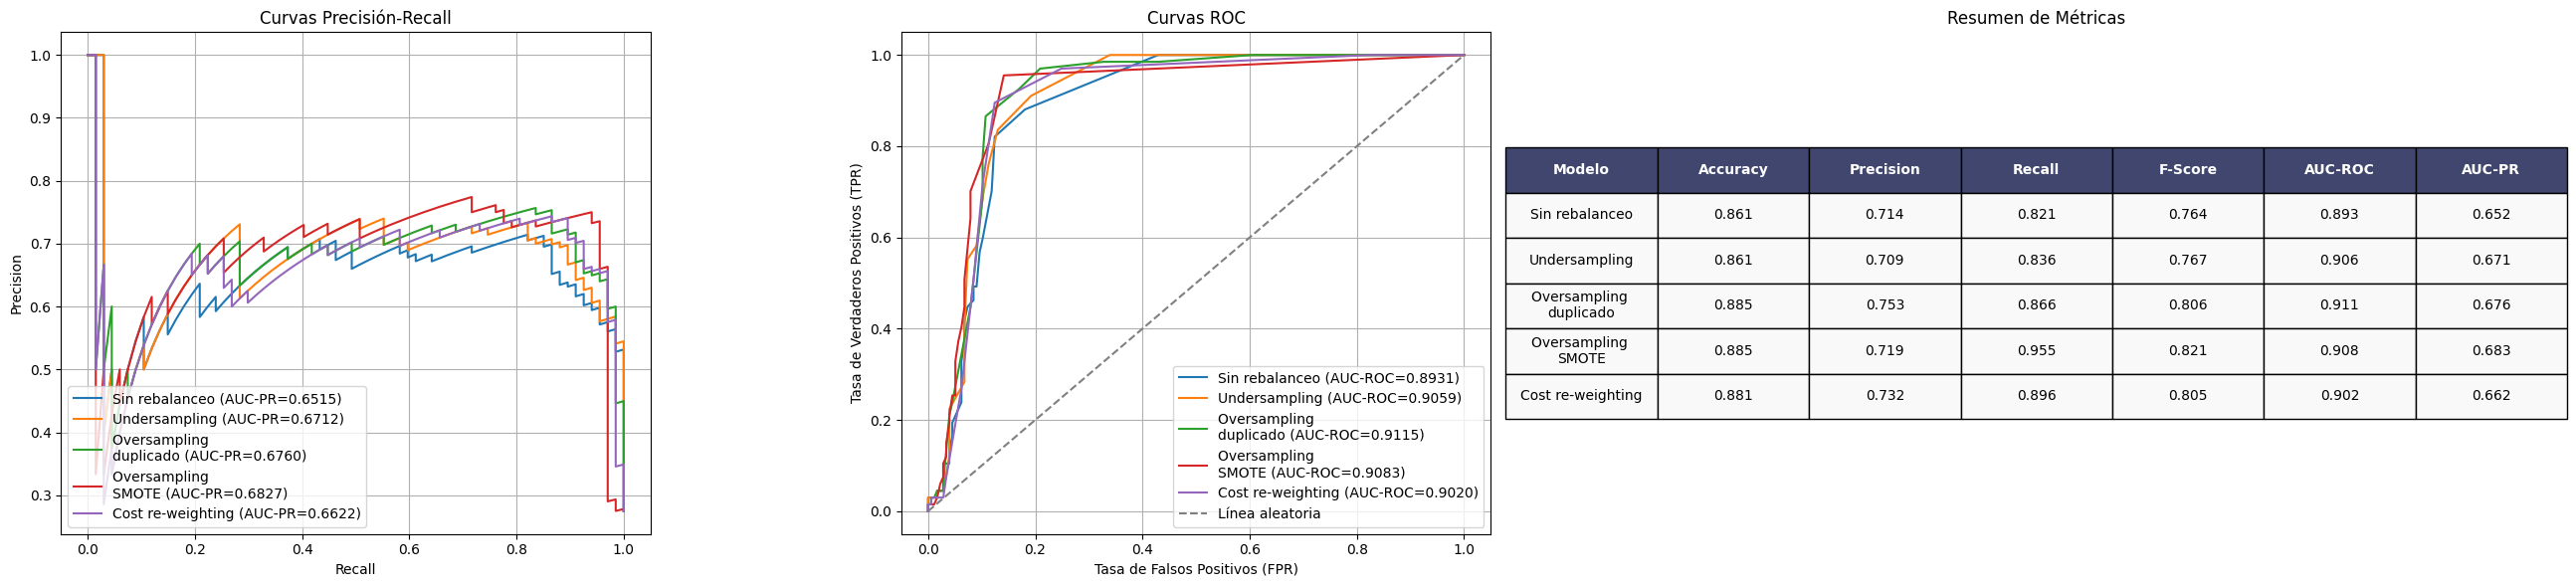

In [ ]:
from Problema1.src.preprocessing import smote, under_sample, oversample_duplication
from Problema1.src.visualization import plot_all_metrics
from Problema1.src.utils import evaluar_modelo

# Dividir datos en entrenamiento y validación
train, val = train_val_split(df_dev, split=0.8)

resultados = []

# 1. Sin rebalanceo
model_sin = train_best_logistic_model(X_train, y_train, X_val, y_val)
resultados.append(evaluar_modelo("Sin rebalanceo", model_sin, X_val, y_val))

# 2. Undersampling
train_under = under_sample(train, 'Diagnosis')
X_u = train_under.drop("Diagnosis", axis=1)
y_u = train_under["Diagnosis"]
model_u = train_best_logistic_model(X_u, y_u, X_val, y_val)
resultados.append(evaluar_modelo("Undersampling", model_u, X_val, y_val))

# 3. Oversampling (duplicado)
train_over = oversample_duplication(train, 'Diagnosis')
X_o = train_over.drop("Diagnosis", axis=1)
y_o = train_over["Diagnosis"]
model_o = train_best_logistic_model(X_o, y_o, X_val, y_val)
resultados.append(evaluar_modelo("Oversampling \nduplicado", model_o, X_val, y_val))

# 4. SMOTE
train_smote = smote(train, 'Diagnosis', k=5)
X_s = train_smote.drop("Diagnosis", axis=1)
y_s = train_smote["Diagnosis"]
model_s = train_best_logistic_model(X_s, y_s, X_val, y_val)
resultados.append(evaluar_modelo("Oversampling \nSMOTE", model_s, X_val, y_val))

# 5. Cost re-weighting
pi = y_train.value_counts(normalize=True)
weights = {0: pi[1], 1: pi[0]}
model_cost = train_best_logistic_model(X_train, y_train, X_val, y_val, weights=weights)
resultados.append(evaluar_modelo("Cost re-weighting", model_cost, X_val, y_val))

for name, model in [("Sin rebalanceo", model_sin), 
                    ("Undersampling", model_u), 
                    ("Oversampling \nduplicado", model_o), 
                    ("Oversampling \nSMOTE", model_s), 
                    ("Cost re-weighting", model_cost)]:
    model.show_hyperparameters(name)

plot_all_metrics(resultados, y_val)

Los modelos fueron entrenados y seleccionados usando la métrica de **`F-score`**, dado que buscamos un buen equilibrio entre **`precisión`** y **`recall`**. Tal como muestran los resultados, esta métrica mejora progresivamente a medida que aplicamos distintas técnicas de balanceo.

Los métodos que lograron los **mejores desempeños** fueron **`SMOTE`** y **`cost re-weighting`**, destacándose por su alta capacidad de detección sin sacrificar precisión. A continuación, evaluaremos estos modelos sobre el conjunto de **`test`**, con el objetivo de observar su rendimiento en una situación realista.

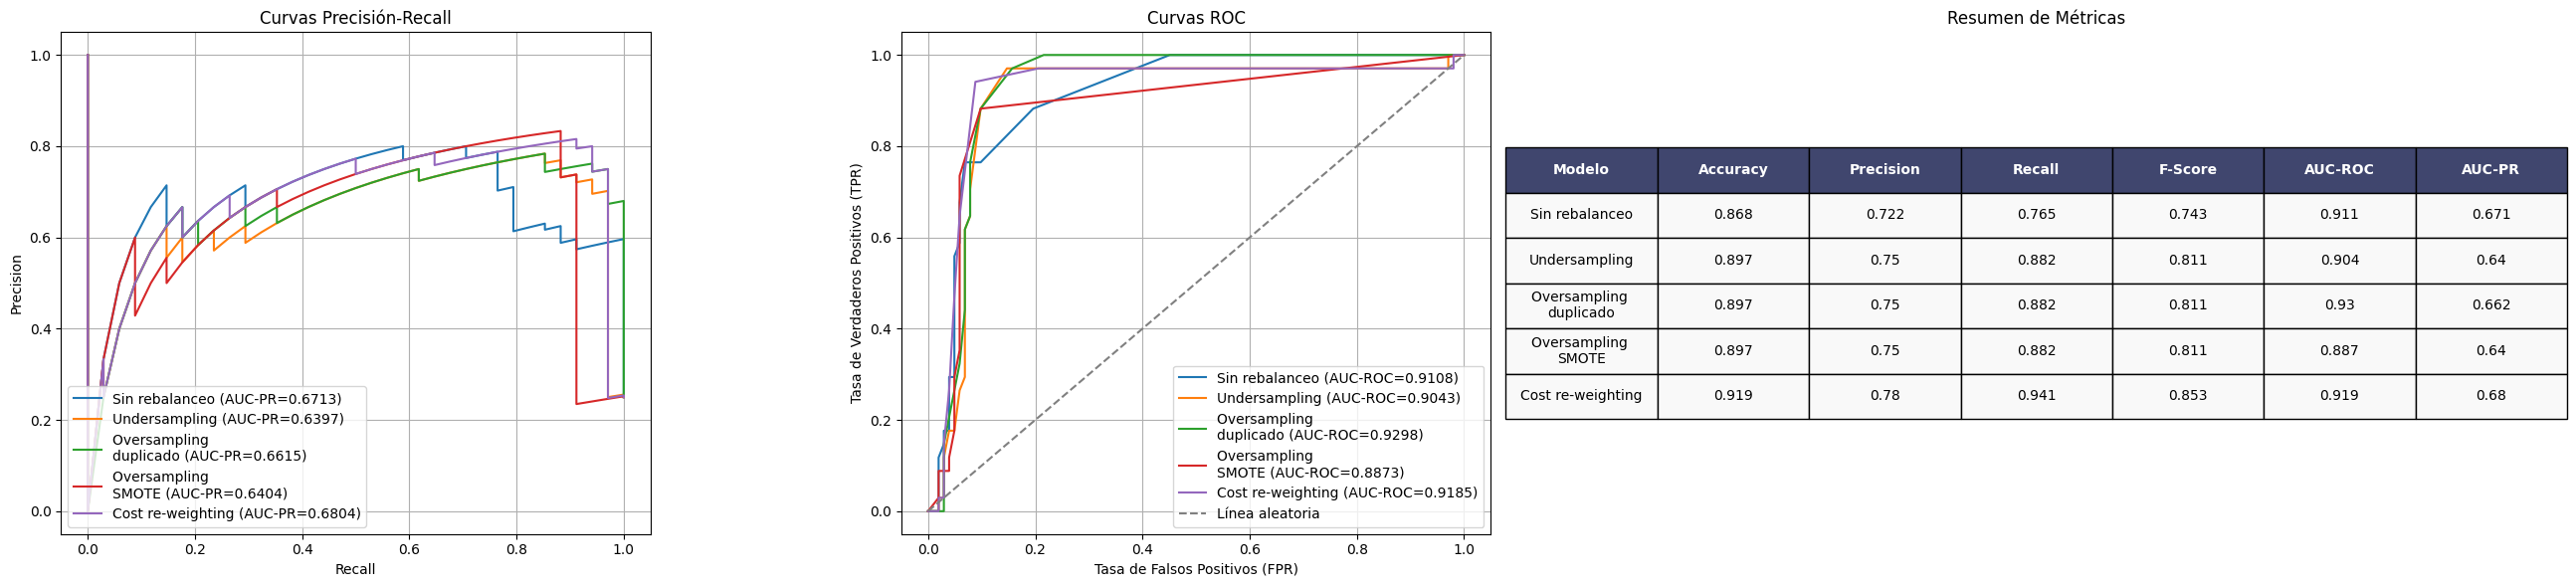

In [ ]:
resultados = []

# 1. Sin rebalanceo
resultados.append(evaluar_modelo("Sin rebalanceo", model_sin, X_test, y_test))

# 2. Undersampling
resultados.append(evaluar_modelo("Undersampling", model_u, X_test, y_test))

# 3. Oversampling (duplicado)
resultados.append(evaluar_modelo("Oversampling \nduplicado", model_o, X_test, y_test))

# 4. SMOTE
resultados.append(evaluar_modelo("Oversampling \nSMOTE", model_s, X_test, y_test))

# 5. Cost re-weighting
resultados.append(evaluar_modelo("Cost re-weighting", model_cost, X_test, y_test))

plot_all_metrics(resultados, y_test)


# coef1 = model_s.coef
# coef2 = model_cost.coef

# # Diferencia absoluta promedio
# print("Diferencia absoluta media:", np.mean(np.abs(coef1 - coef2)))

# # Si querés graficar ambos
# plt.figure(figsize=(10,5))
# plt.plot(coef1, label='SMOTE', marker='o')
# plt.plot(coef2, label='Cost re-weighting', marker='x')
# plt.title("Comparación de coeficientes")
# plt.xlabel("Feature index")
# plt.ylabel("Peso")
# plt.legend()
# plt.grid(True)
# plt.show()

# print("SMOTE:", y_s.value_counts().to_dict())
# print("Cost weight:", weigths)
# print("Params SMOTE:", model_s.lr, model_s.L2, model_s.threshold)
# print("Params CostWeight:", model_cost.lr, model_cost.L2, model_cost.threshold)


Al observar los resultados sobre el conjunto de `test`, se confirma que los métodos de balanceo mejoran notablemente el rendimiento del modelo respecto al caso sin rebalanceo. El `oversampling con SMOTE` y el `cost re-weighting` se consolidan como las estrategias más efectivas, superando a las demás en varias métricas clave.

En particular, **SMOTE** obtuvo el **mejor `F-Score` y `AUC-PR`**, lo cual indica un excelente equilibrio entre precisión y recall, y una muy buena capacidad para identificar correctamente la clase minoritaria. Sin embargo, es importante notar que **SMOTE incorpora un componente aleatorio**, por lo que su desempeño puede **variar levemente entre ejecuciones**. A pesar de eso, se mantiene como una de las mejores alternativas evaluadas.

Por su parte, el método de **`cost re-weighting`** también mostró un rendimiento muy competitivo y más estable, siendo una excelente opción en escenarios donde se requiere mayor robustez frente a variabilidad.

Ambos enfoques se destacan como soluciones efectivas para abordar el desbalance de clases, y su elección puede depender del contexto, recursos disponibles y necesidad de estabilidad en la performance.

**Dataset multiclase**  
Ahora veremos un dataset distinto, para el cual aplicaremos modelos multiclase.  
Empezaremos por explorar el dataset: **features**, sus **rangos**, valores **nulos (NaNs)** y posibles **duplicados**.

In [ ]:
df_dev = pd.read_csv("Problema2/data/raw/WAR_class_dev.csv")
df_test = pd.read_csv("Problema2/data/raw/WAR_class_test.csv")

explore_data(df_dev)

Fragmento aleatorio de muestras


,poss,mp,raptor_total,war_total,pace_impact,war_class
3782,6106.457839,3331.760914,3.696976,10.929735,-0.339489,3
2103,1404.774282,1057.660433,-3.011529,-0.327367,0.277156,2
1647,2110.600199,1083.810395,-6.308455,-1.165510,0.439584,2
1427,4934.378514,2371.723678,-0.229349,2.251975,-0.730388,2
6147,951.440638,394.771345,-8.225431,-1.503870,0.033328,1
1057,5298.537777,2759.207669,5.270528,12.730795,-0.095242,3
3571,5584.204230,2700.278257,4.232459,8.823258,1.135296,3



Rango de valores de cada columna


,poss,mp,raptor_total,war_total,pace_impact,war_class
min,-414.390684,-235.333650,-43.449330,-6.589665,-6.935191,1.0
max,9329.401575,4264.461247,32.904816,28.762877,11.193450,3.0



Categorías con valores faltantes
 Series([], )

Filas duplicadas: 0


**Primera inspección**  
Vemos que **no hay NaNs**, pero sí que los **rangos están fuera de lo permitido**.  
Para analizar mejor los **features** y detectar **outliers**, haremos:
- una **matriz de correlación**
- un **boxplot**
- un **pairplot**

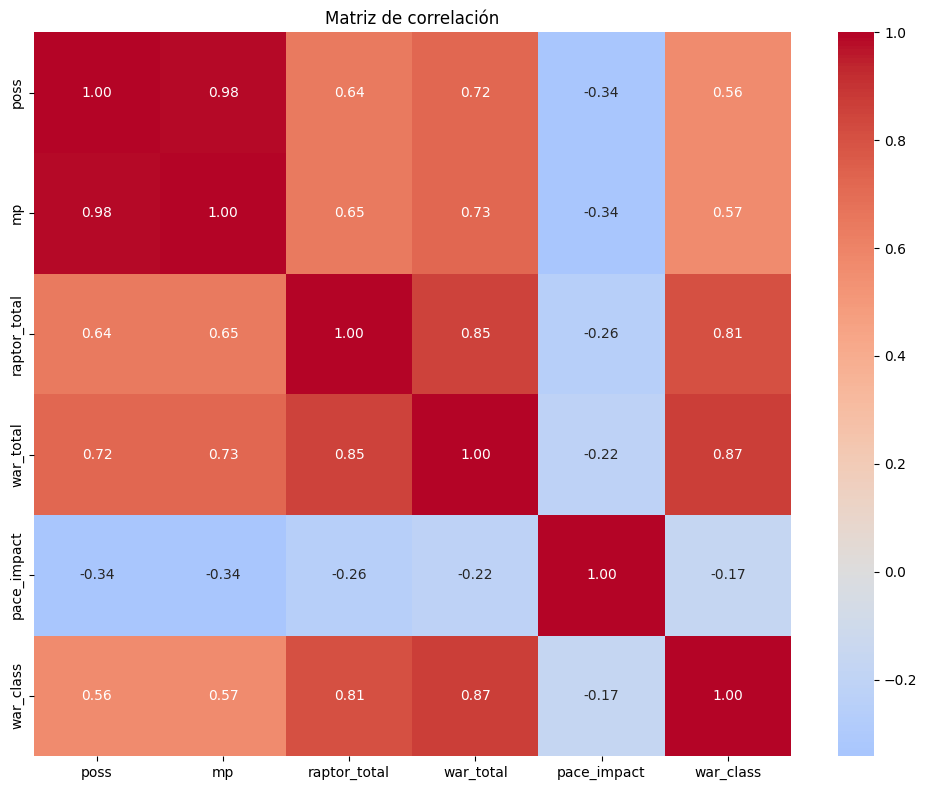

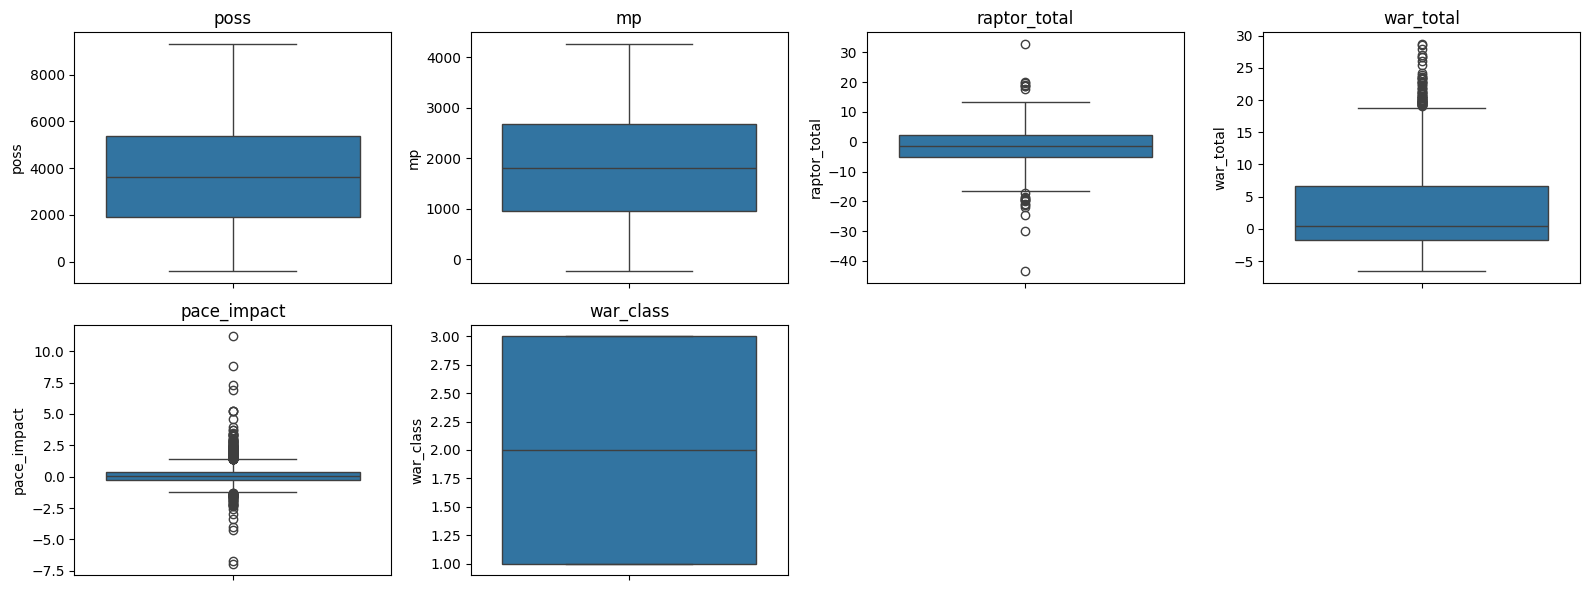

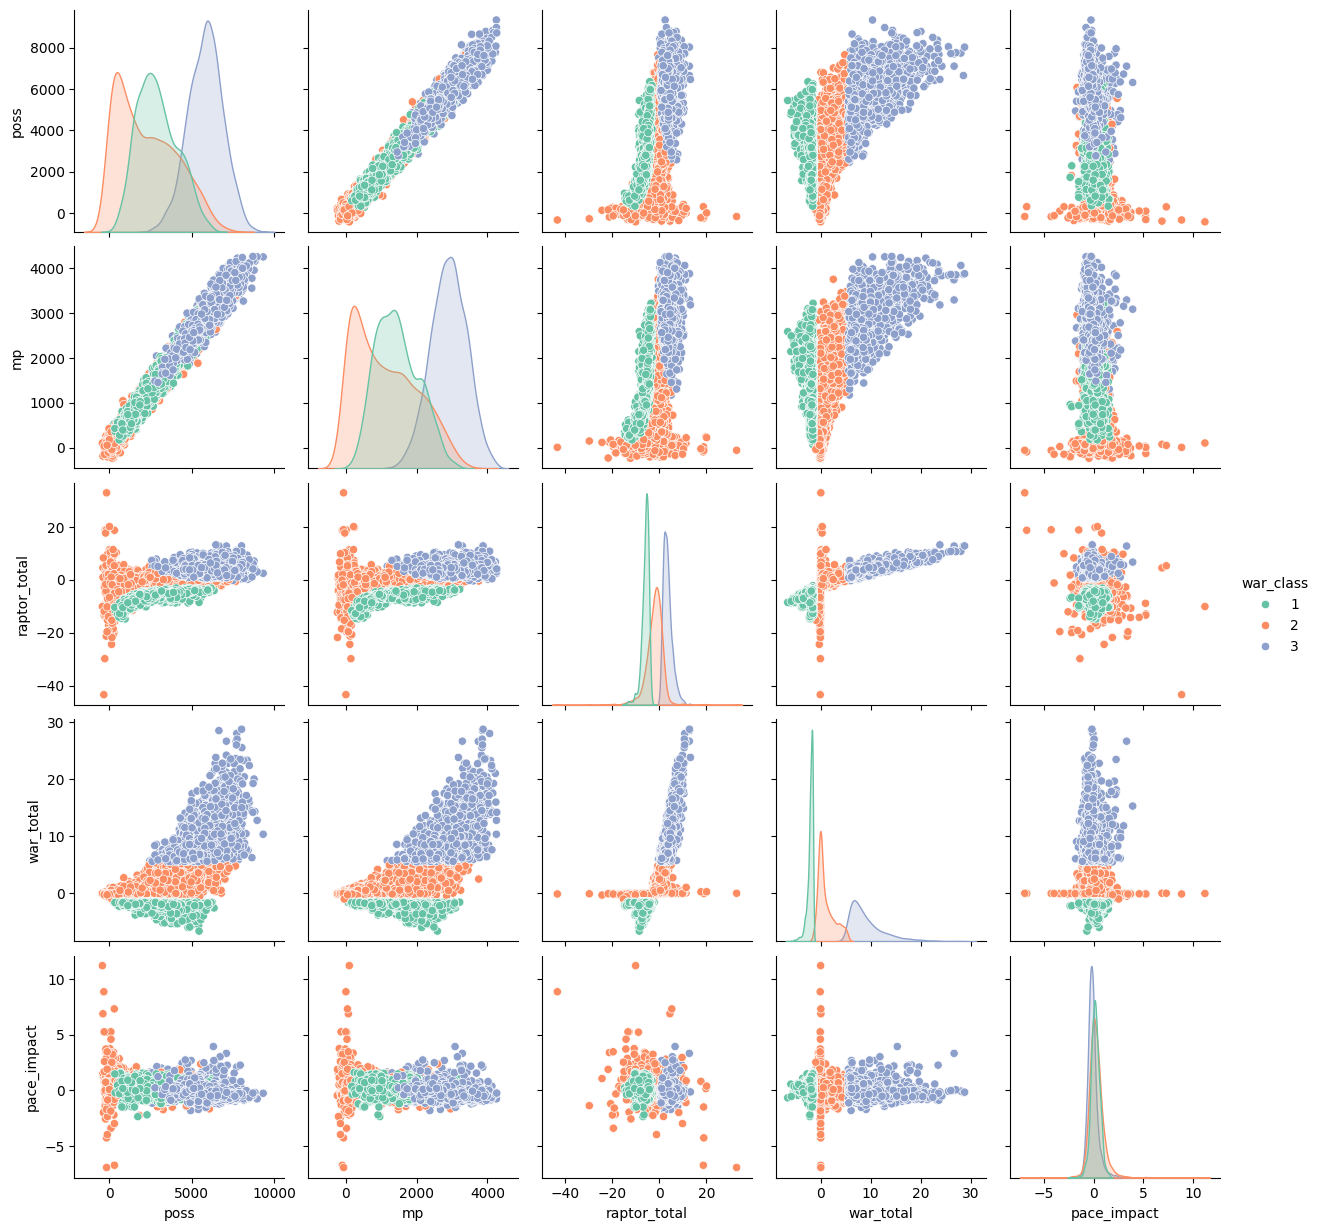

In [ ]:
plot_correlation_matrix(df_dev)
plot_boxplots(df_dev, ['Diagnosis', 'CellType', 'GeneticMutation'])
sns.pairplot(df_dev, hue='war_class', diag_kind='kde', palette='Set2')

**Análisis exploratorio**  
Del **pairplot** vemos que `war_total` explica perfectamente `war_class`, que es nuestra **etiqueta**.  
Probablemente `war_total` tenga incluida la info de `war_class`, así que la eliminamos por ser **trivial**.  
  
Respecto a los **outliers**, aunque hay valores extremos en el rendimiento, asumimos que hay jugadores **excepcionales**.  
Solo eliminamos outliers **imposibles** (como posesiones negativas).  
Podemos darnos ese lujo porque **no perdemos mucha información** y **prevenimos errores**.

**Train/Validation y balanceo**  
Dividimos los datos en **train y validation (80/20)**.  
Usamos **SMOTE** para balancear las clases, ya que el dataset está desbalanceado.  
Elegimos SMOTE porque vimos anteriormente que es uno de los **mejores métodos**.

In [ ]:
df_dev.drop(columns=["war_total"], inplace=True)
df_test.drop(columns=["war_total"], inplace=True)
limits = {'poss': (0, np.inf), 'mp': (0, np.inf)}
clean_outliers(df_dev, limits)
clean_outliers(df_test, limits)
df_dev.dropna(inplace=True)
df_test.dropna(inplace=True)

print(df_dev['war_class'].value_counts(normalize=True))
train, val = train_val_split(df_dev, split=0.8, shuffle=True)
train_smote = smote(train, 'war_class', k=5)
print(train_smote['war_class'].value_counts(normalize=True))

war_class
2    0.351396
3    0.340619
1    0.307984
Name: proportion, dtype: float64
war_class
2    0.333333
3    0.333333
1    0.333333
Name: proportion, dtype: float64


**Preparación de datos**  
Separamos `X` e `y`, y dividimos en **train** y **validation**.  
Normalizamos usando **RobustScaler**, ya que hay features con valores **atípicos** debido a jugadores que **sobresalen**.


In [ ]:
# Separar features y target
X_train = train_smote.drop("war_class", axis=1)
y_train = train_smote["war_class"]
X_val = val.drop("war_class", axis=1)
y_val = val["war_class"]
X_test = df_test.drop("war_class", axis=1)
y_test = df_test["war_class"]

# Features a escalar
features_robust = ['poss', 'mp', 'raptor_total', 'pace_impact']

# Fit con train
mediana, iqr = robust_fit(X_train[features_robust])

# Transform
X_train[features_robust] = robust_transform(X_train[features_robust], mediana, iqr)
X_val[features_robust] = robust_transform(X_val[features_robust], mediana, iqr)
X_test[features_robust] = robust_transform(X_test[features_robust], mediana, iqr)

df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)
df_dev = pd.concat([df_train, df_val], axis=0)
df_test = pd.concat([X_test, y_test], axis=1)
df_dev.to_csv("Problema2/data/processed/WAR_class_dev.csv", index=False)
df_test.to_csv("Problema2/data/processed/WAR_class_test.csv", index=False)

**Modelos utilizados**  
Implementamos tres modelos:
- `RandomForest`
- `LinearDiscriminantAnalysis`
- `Multiclass Logistic Regression`

Para **RandomForest** y **LogisticRegression**, buscamos los **mejores hiperparámetros** y evaluamos su desempeño en **validation**.

LDA
Mejor F-score: 0.9179228180935302 con lr=0.1, lambda=0
Mejor F-score: 0.9656728079786147 con n_trees=10, max_depth=15, min_samples_split=2


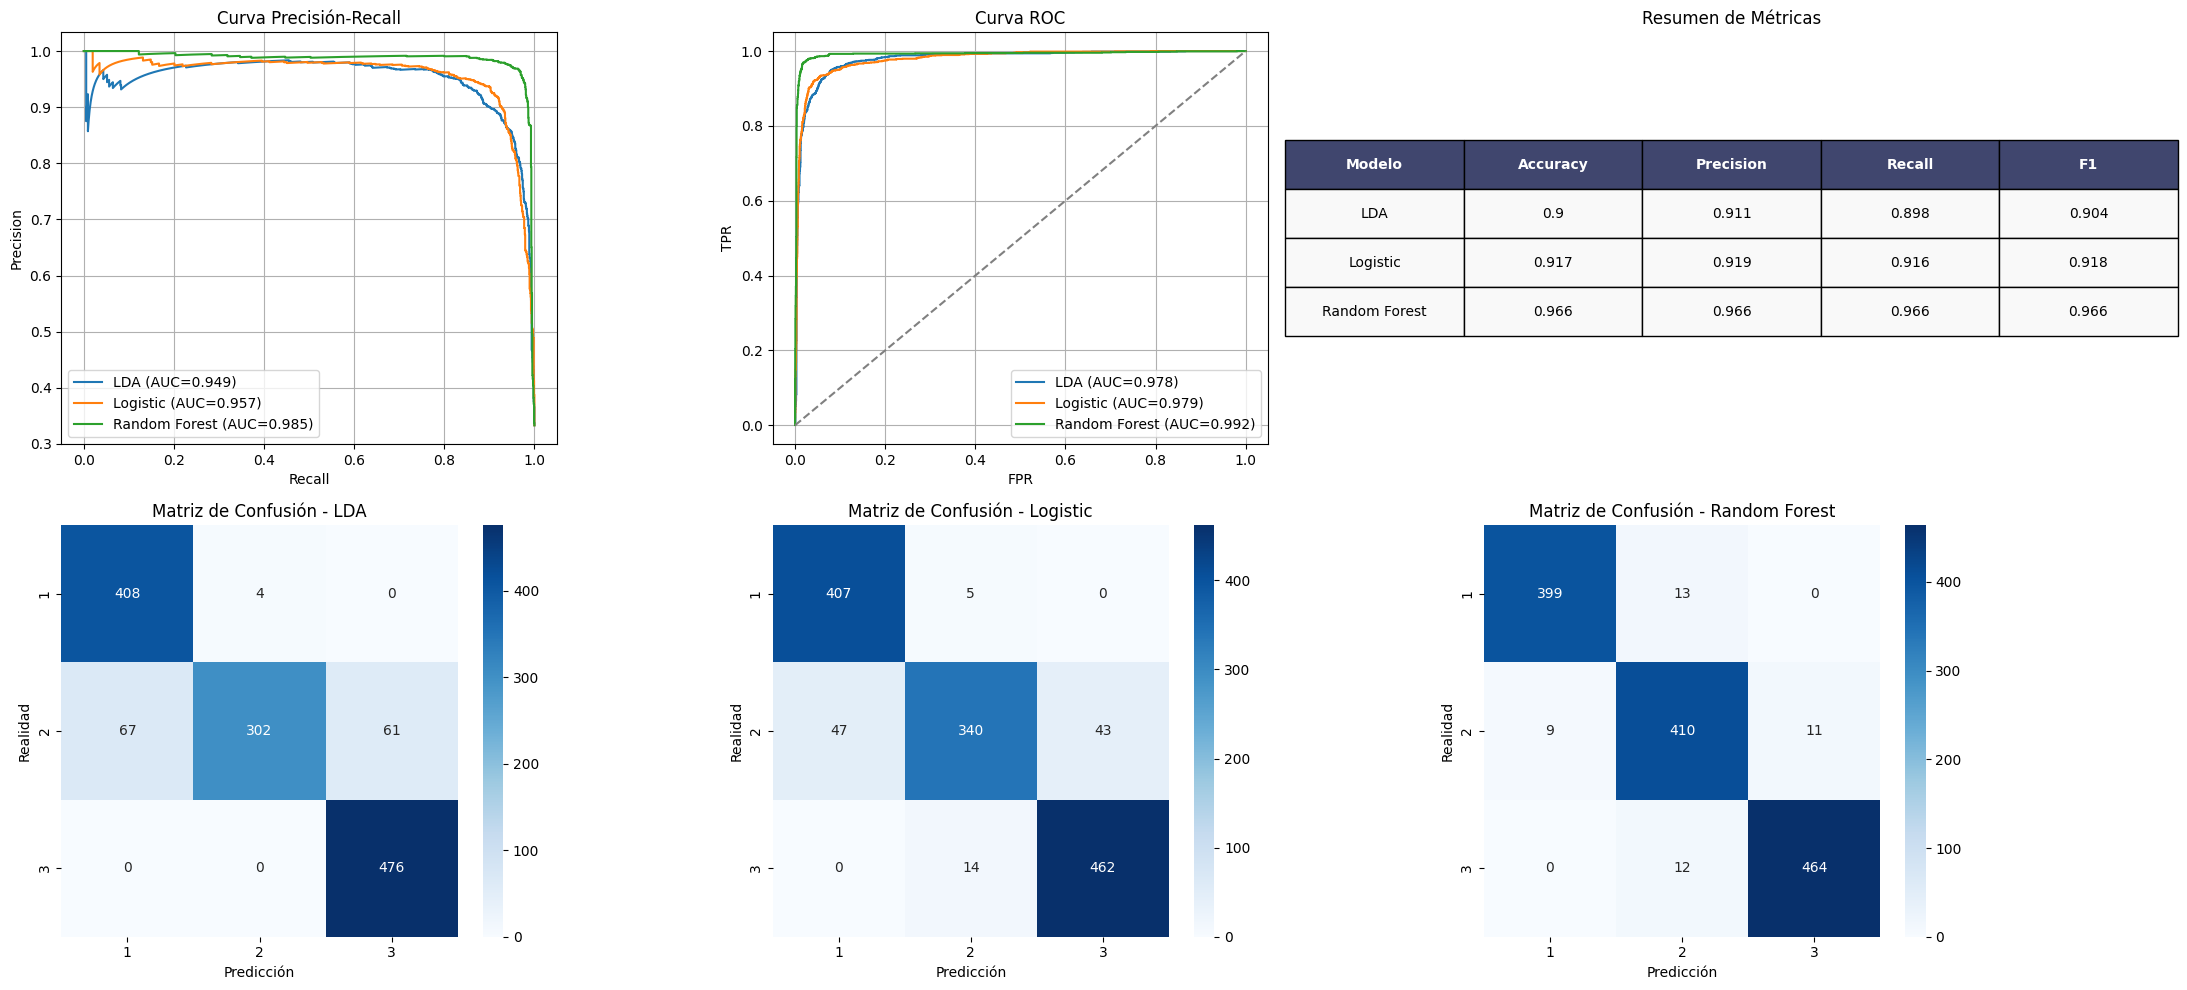

In [ ]:
from Problema2.src.utils import train_best_random_forest, train_best_multiclass_logistic_model
from Problema2.src.models import LinearDiscriminantAnalysis
from Problema2.src.utils import compare_all_metrics

model_lda = LinearDiscriminantAnalysis(X_train, y_train)
print("LDA")
y_pred_lda = model_lda.predict(X_val)
y_prob_lda = model_lda.predict_proba(X_val)


model_logistic = train_best_multiclass_logistic_model(X_train, y_train, X_val, y_val)
y_pred_log = model_logistic.predict(X_val)
y_prob_log = model_logistic.predict_proba(X_val)

model_forest = train_best_random_forest(X_train, y_train, X_val, y_val)
y_pred_forest = model_forest.predict(X_val)
y_prob_forest = model_forest.predict_proba(X_val)

compare_all_metrics(
    [y_val]*3,
    [y_prob_lda, y_prob_log, y_prob_forest],
    [y_pred_lda, y_pred_log, y_pred_forest],
)


**Comparación de modelos (Validation)**  
`LDA` y `ML` tienen desempeños **similares**, pero `RandomForest` es **notablemente mejor**.  
Ahora, evaluamos en **test**.

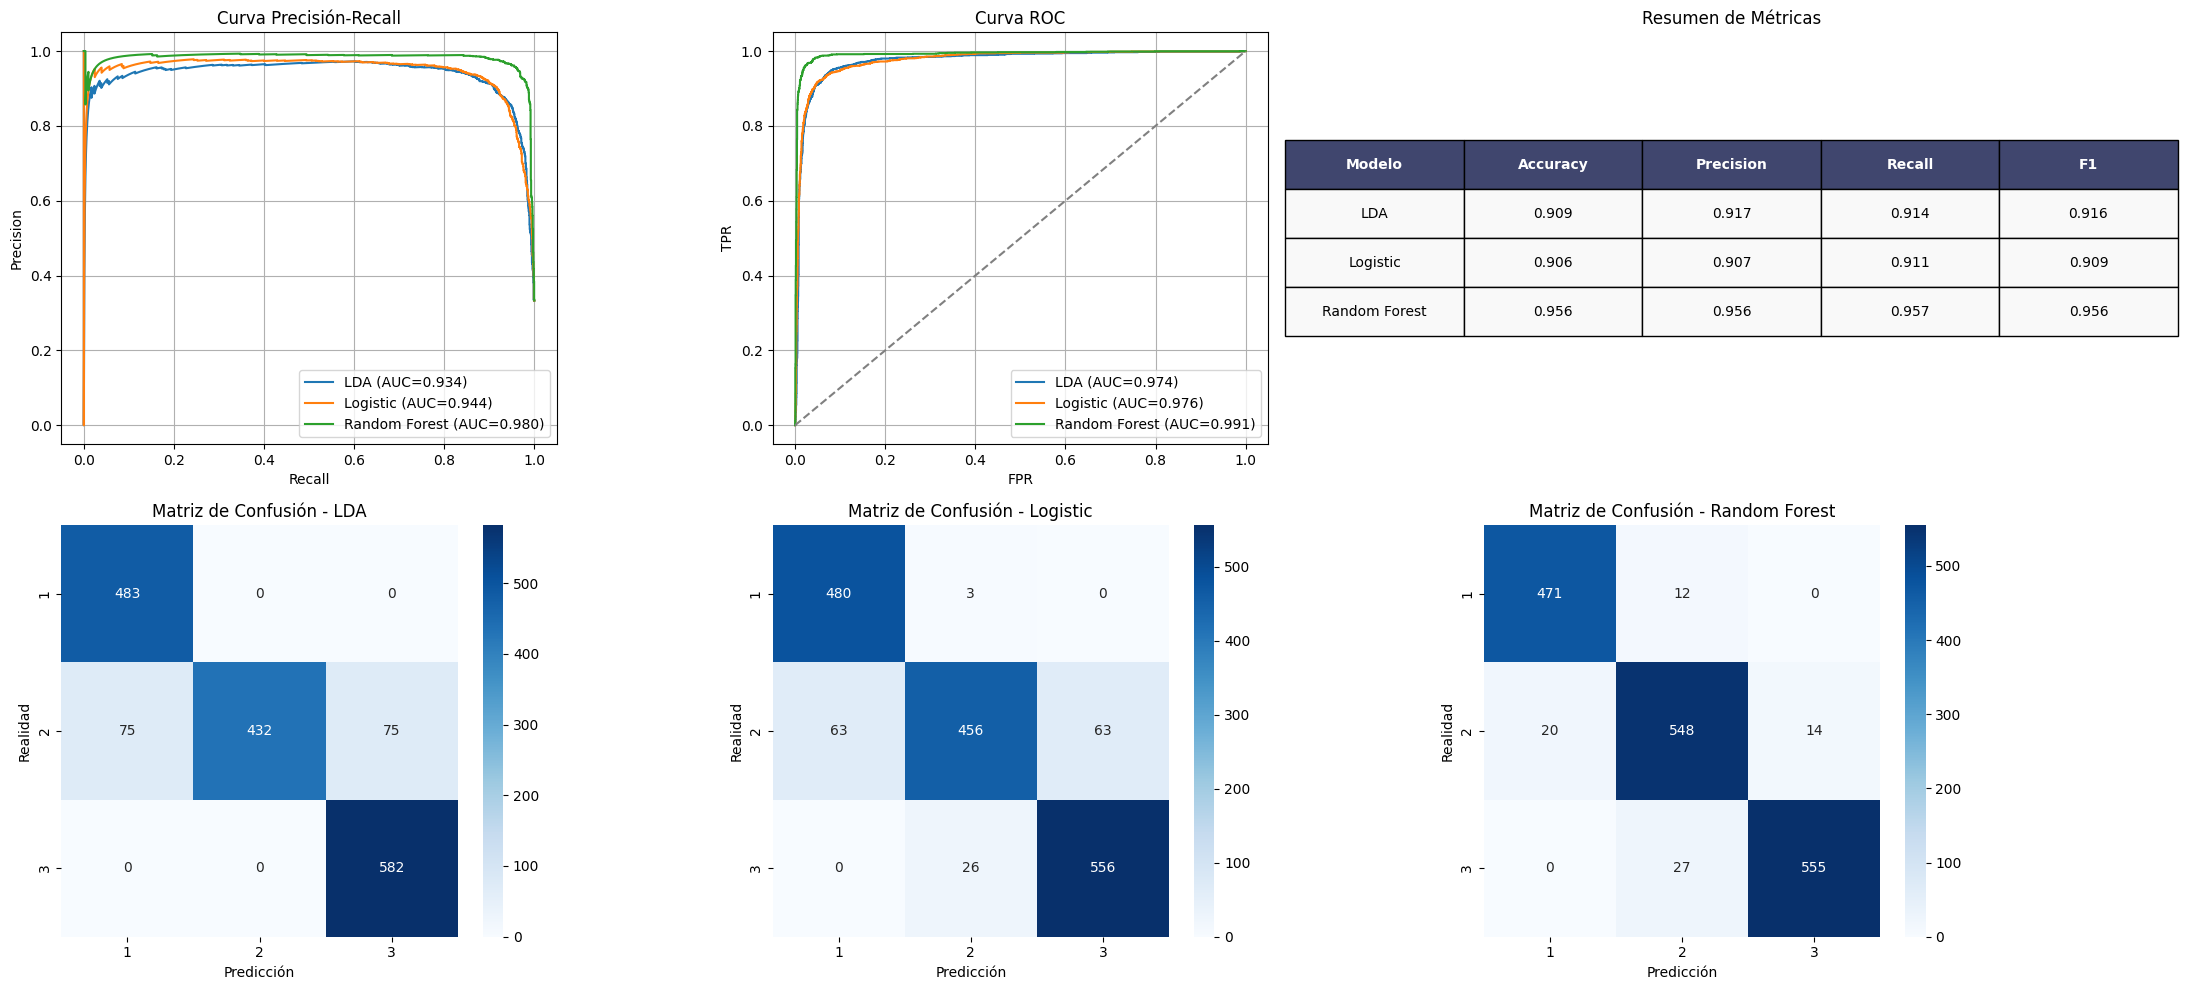

In [ ]:
y_pred_lda = model_lda.predict(X_test)
y_prob_lda = model_lda.predict_proba(X_test)

y_pred_log = model_logistic.predict(X_test)
y_prob_log = model_logistic.predict_proba(X_test)

y_pred_forest = model_forest.predict(X_test)
y_prob_forest = model_forest.predict_proba(X_test)

compare_all_metrics(
    [y_test]*3,
    [y_prob_lda, y_prob_log, y_prob_forest],
    [y_pred_lda, y_pred_log, y_pred_forest],
)


**Resultados**:  
- **Multiclass Logistic Regression** fue **ligeramente inferior** a **LDA**, mostrando métricas aceptables pero algo limitadas en precisión promedio.  
- **LDA** presentó un rendimiento algo mejor que Logistic Regression, aunque sin diferencias significativas.  
- **Random Forest** tuvo **métricas notablemente superiores**, destacándose con un excelente equilibrio entre precisión, recall y F1.  

Ahora, entrenamos nuevamente cada modelo utilizando el conjunto completo de **train + validation**, asegurando que dispongan de la máxima cantidad de datos para aprender. Luego, hacemos predicciones finales en el conjunto de **test** reservado exclusivamente para evaluación.  


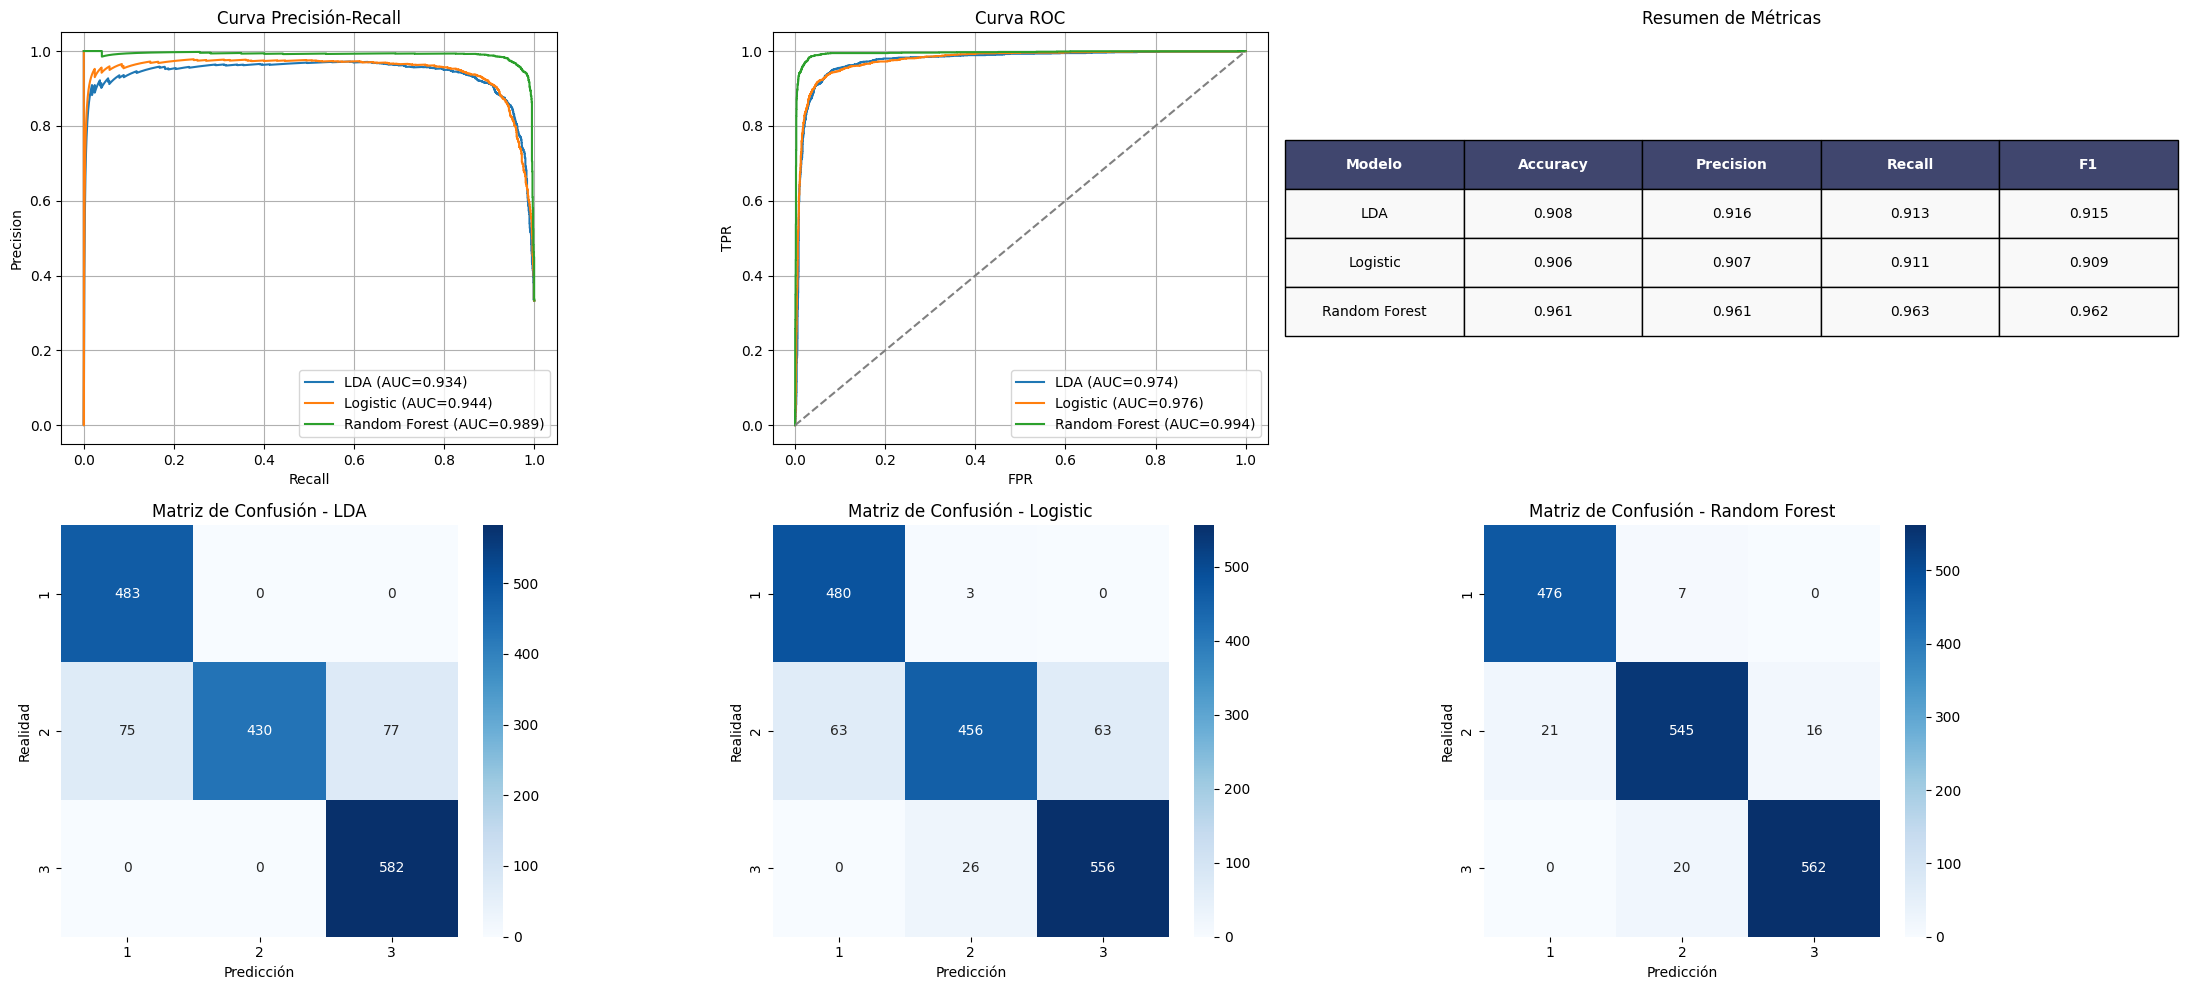

In [ ]:
from Problema2.src.models import RandomForest, MulticlassLogisticRegression
X_dev = pd.concat([X_train, X_val], axis=0)
y_dev = pd.concat([y_train, y_val], axis=0)

model_lda = LinearDiscriminantAnalysis(X_dev, y_dev)
model_log = MulticlassLogisticRegression(X_dev, y_dev, lr=0.1, L2=0.001)
model_forest = model = RandomForest(n_trees=20, max_depth=10, min_samples_split=2)
model_forest.fit(X_dev, y_dev)

y_pred_lda = model_lda.predict(X_test)
y_prob_lda = model_lda.predict_proba(X_test)

y_pred_log = model_logistic.predict(X_test)
y_prob_log = model_logistic.predict_proba(X_test)

y_pred_forest = model_forest.predict(X_test)
y_prob_forest = model_forest.predict_proba(X_test)

compare_all_metrics(
    [y_test]*3,
    [y_prob_lda, y_prob_log, y_prob_forest],
    [y_pred_lda, y_pred_log, y_pred_forest],
)


**Resultados**:  
El entrenamiento con **train + validation** y posterior evaluación en **test** mostró que los modelos **rindieron casi idéntico** a los resultados obtenidos previamente. Esto valida la estabilidad de los hiperparámetros seleccionados y confirma la robustez de los modelos. **Random Forest** mantuvo su ventaja destacada, reafirmándose como la opción más confiable y precisa.  

**Conclusión**:  
Los modelos ajustados en **train + validation** se comportaron de manera consistente, consolidando a **Random Forest** como la elección óptima para esta tarea.  